# Exercise 1: Introduction to GenAI

## Part 1: PyTorch Refresher - Building a 2D Classifier

In [1]:
# TODO: Make necessary imports
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
import seaborn as sns
import time
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# TASK: Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

# TODO: Check for GPU acceleration and use if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


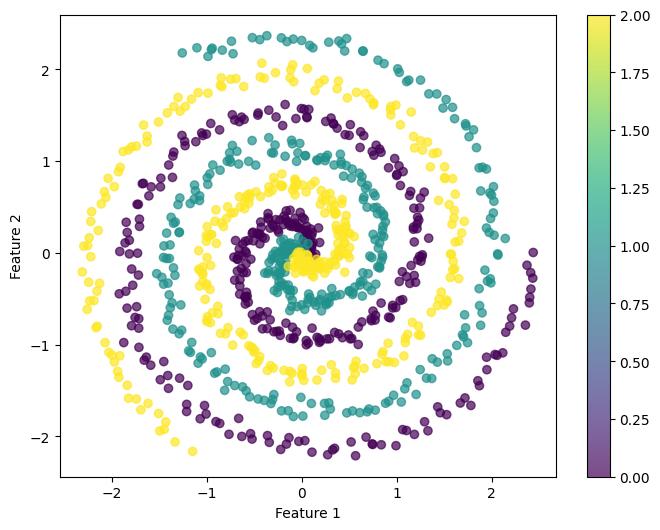

Dataset shape: torch.Size([999, 2])
Class distribution: [333 333 333]


In [2]:
# Generate 2D classification dataset
def generate_classification_data(n_samples=1000, n_classes=4, device=device):
    """Generate 2D classification datasets"""
    
    # Multi-class spiral
    
    points_per_class = n_samples // n_classes
    X, labels = [], []

    
    
    for class_id in range(n_classes):
        # Create spiral arms with different starting angles
        t = np.linspace(0.1, 4*np.pi, points_per_class)
        radius = t
        angle = t + (class_id * 2*np.pi / n_classes)
        
        x_coords = radius * np.cos(angle) + np.random.normal(0, 0.3, points_per_class)
        y_coords = radius * np.sin(angle) + np.random.normal(0, 0.3, points_per_class)
        
        X.append(np.column_stack([x_coords, y_coords]))
        labels.append(np.full(points_per_class, class_id))
        
    X = np.vstack(X)
    y = np.concatenate(labels)
        
    # Normalize to reasonable range
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    
    return torch.FloatTensor(X).to(device), torch.LongTensor(y).to(device)


# TODO: Generate and Visualize the data

n_cls = 3
X, y = generate_classification_data(n_samples=1000, n_classes=n_cls)

# Visualize the dataset
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X[:, 0].cpu(), X[:, 1].cpu(), c=y.cpu(), cmap='viridis', alpha=0.7)
plt.colorbar(scatter)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

print(f"Dataset shape: {X.shape}")
print(f"Class distribution: {np.bincount(y.cpu())}")

In [3]:
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=[64, 32], output_dim=2):
        super(SimpleClassifier, self).__init__()
        
        # TODO: Define your network layers here
        layers = []
        prev_dim = input_dim
        
        # Create hidden layers dynamically
        for h in hidden_dim:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            prev_dim = h
        
        # Final output layer
        layers.append(nn.Linear(prev_dim, output_dim))
        
        # Register all layers as a Sequential model
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        # TODO: Implement forward pass
        return  self.network(x)

# TODO: Initialize the model, loss, and optimizer
model = SimpleClassifier(hidden_dim=[256, 128, 64], output_dim=n_cls).to(device)
print(model)
criterion = nn.CrossEntropyLoss()  # Multi-class classification loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

SimpleClassifier(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=3, bias=True)
  )
)
Total parameters: 42115


In [4]:
# TODO: Create data splits (train/test)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch

# stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X.cpu().numpy(), y.cpu().numpy(), test_size=0.2, random_state=42, shuffle=True, stratify=y.cpu().numpy()
)

# scale using train stats only
scaler = StandardScaler().fit(X_train)
X_train = torch.tensor(scaler.transform(X_train), dtype=torch.float32).to(device)
X_test  = torch.tensor(scaler.transform(X_test),  dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test  = torch.tensor(y_test,  dtype=torch.long).to(device)


In [5]:
# Training function
def train_model(model, X_train, y_train, epochs=100):
    model.train()
    losses, accuracies = [], []
    
    for epoch in range(epochs):
        
        #TODO: Implement model training
        optimizer.zero_grad()
        
        outputs = model(X_train)               
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())

        # Accuracy
        _, predicted = torch.max(outputs.data, 1)
        accuracy = (predicted == y_train).float().mean().item()
        accuracies.append(accuracy)
        
        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.3f}')
    
    return losses, accuracies


# Train the model
losses, accuracies = train_model(model, X_train, y_train, epochs=200)

Epoch [20/200], Loss: 1.0519, Accuracy: 0.504
Epoch [40/200], Loss: 1.0039, Accuracy: 0.398
Epoch [60/200], Loss: 0.9048, Accuracy: 0.512
Epoch [80/200], Loss: 0.7491, Accuracy: 0.721
Epoch [100/200], Loss: 0.5365, Accuracy: 0.901
Epoch [120/200], Loss: 0.3351, Accuracy: 0.952
Epoch [140/200], Loss: 0.2044, Accuracy: 0.970
Epoch [160/200], Loss: 0.1317, Accuracy: 0.977
Epoch [180/200], Loss: 0.0931, Accuracy: 0.985
Epoch [200/200], Loss: 0.0716, Accuracy: 0.986


In [6]:
# TODO: Evaluate model
model.eval()

with torch.no_grad():
    # Test accuracy
    test_outputs = model(X_test)
    _, predicted = torch.max(test_outputs, 1)
    accuracy = (predicted == y_test).float().mean()
    print(f'Test Accuracy: {accuracy.item():.2%}')

Test Accuracy: 96.00%


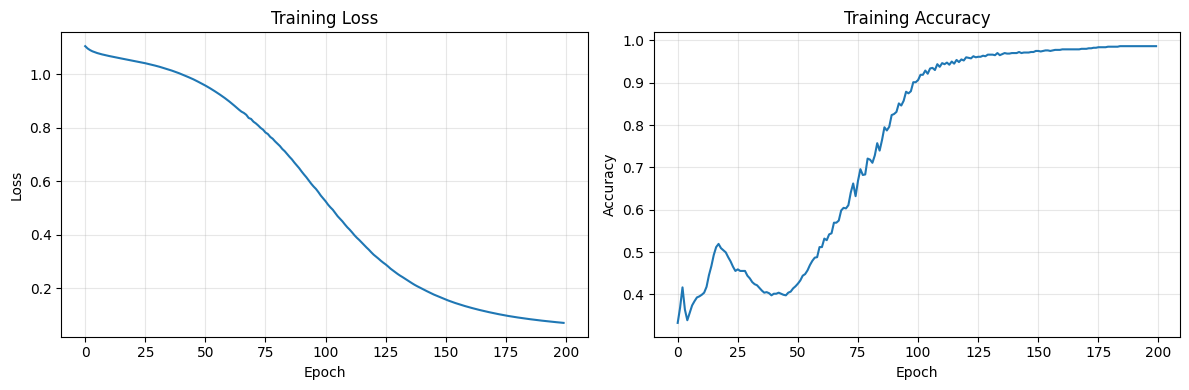

In [7]:
# TODO: Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Loss curve
ax1.plot(losses)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.grid(True, alpha=0.3)

# Accuracy curve
ax2.plot(accuracies)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training Accuracy')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

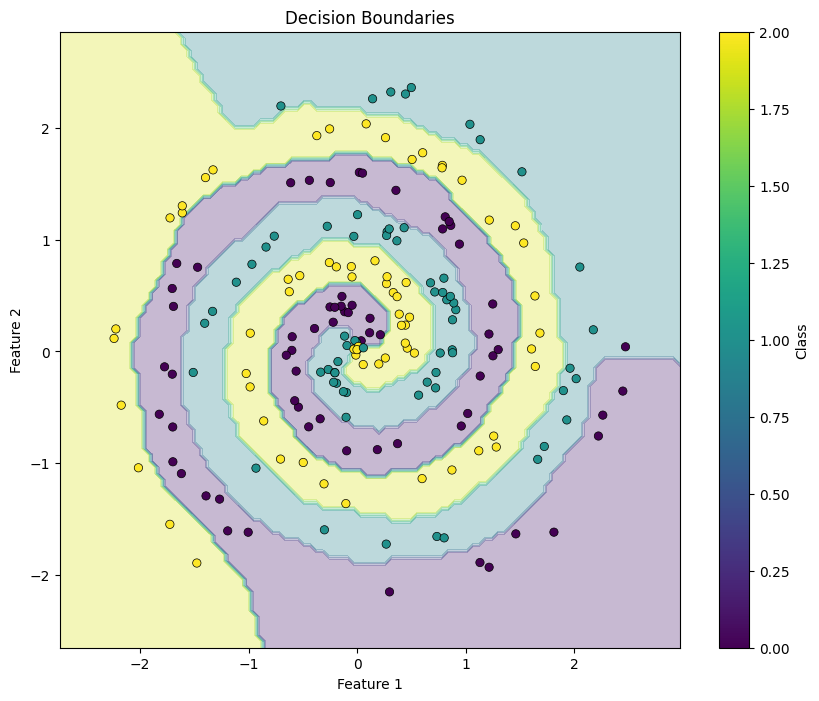

In [8]:
# TODO: Optional Decision Boundary Visualization

def plot_decision_boundary(model, X, y, resolution=100):
    """
    Plot decision boundaries learned by the model.
    """
    model.eval()
    
    # Create mesh grid
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, resolution),
        np.linspace(y_min, y_max, resolution)
    )
    
    # Predict on mesh grid
    grid_points = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]).to(device)
    
    with torch.no_grad():
        Z = model(grid_points)
        _, Z = torch.max(Z, 1)
        Z = Z.cpu().numpy().reshape(xx.shape)
    
    # Plot
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    scatter = plt.scatter(X[:, 0].cpu(), X[:, 1].cpu(), 
                         c=y.cpu(), cmap='viridis', 
                         edgecolor='black', linewidth=0.5)
    plt.colorbar(scatter, label='Class')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundaries')
    plt.show()

# Visualize decision boundaries
plot_decision_boundary(model, X_test.cpu(), y_test.cpu())

## Part 2: From Classification to Generation (Demo)

In [9]:
def setup_device():
    """
    Automatically detect and setup the best available device(s)
    Returns device and whether multiple GPUs are available
    """
    if torch.cuda.is_available():
        num_gpus = torch.cuda.device_count()
        device = torch.device('cuda:0')
        
        print(f"GPU acceleration enabled!")
        print(f"   Available GPUs: {num_gpus}")
        for i in range(num_gpus):
            gpu_name = torch.cuda.get_device_name(i)
            gpu_memory = torch.cuda.get_device_properties(i).total_memory / 1e9
            print(f"   GPU {i}: {gpu_name} ({gpu_memory:.1f}GB)")
        
        multi_gpu = num_gpus > 1
        if multi_gpu:
            print(f"Multi-GPU training will be used ({num_gpus} GPUs)")
        
        return device, multi_gpu
    else:
        print("No GPU detected, using CPU")
        print("   Note: Training will be slower but still functional")
        return torch.device('cpu'), False

In [10]:
class Generator(nn.Module):
    """ Generator Network """
    
    def __init__(self, noise_dim=10, hidden_dim=128):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(noise_dim, hidden_dim),
            nn.ReLU(True),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(True),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 2),
            nn.Tanh()
        )
        
        # Better weight initialization
        self.apply(self._weights_init)
    
    def _weights_init(self, m):
        """Custom weight initialization for better training stability"""
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.zeros_(m.bias)
    
    def forward(self, noise):
        return self.net(noise)

In [11]:
class Discriminator(nn.Module):
    """Discriminator Network"""
    
    def __init__(self, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.LeakyReLU(0.2, True),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2, True),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 64),
            nn.LeakyReLU(0.2, True),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        
        # Better weight initialization
        self.apply(self._weights_init)
    
    def _weights_init(self, m):
        """Custom weight initialization for better training stability"""
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.zeros_(m.bias)
    
    def forward(self, x):
        return self.net(x).view(-1)

In [12]:
def generate_real_data(n_samples=5000, dataset_type='figure8', device='cpu'):
    """Generate different types of 2D datasets"""
    
    if dataset_type == 'circles':
        data, _ = make_circles(n_samples=n_samples, noise=0.05, factor=0.4)
        
    elif dataset_type == 'moons':
        data, _ = make_moons(n_samples=n_samples, noise=0.05)
        
    elif dataset_type == 'blobs':
        data, _ = make_blobs(n_samples=n_samples, centers=3, cluster_std=0.4)
        
    elif dataset_type == 'spiral':
        t = np.linspace(0, 3*np.pi, n_samples)
        r = t / (3*np.pi) * 2
        x = r * np.cos(t) + np.random.normal(0, 0.05, n_samples)
        y = r * np.sin(t) + np.random.normal(0, 0.05, n_samples)
        data = np.column_stack([x, y])
        
    elif dataset_type == 'figure8':
        # Better figure-8 pattern
        t = np.linspace(0, 2*np.pi, n_samples)
        scale = 0.8
        x = scale * np.sin(t) + np.random.normal(0, 0.03, n_samples)
        y = scale * np.sin(2*t) / 2 + np.random.normal(0, 0.03, n_samples)
        data = np.column_stack([x, y])
        
    elif dataset_type == 'heart':
        # Heart shape for fun!
        t = np.linspace(0, 2*np.pi, n_samples)
        x = 16 * np.sin(t)**3
        y = 13 * np.cos(t) - 5 * np.cos(2*t) - 2 * np.cos(3*t) - np.cos(4*t)
        x = x / 20 + np.random.normal(0, 0.03, n_samples)
        y = y / 20 + np.random.normal(0, 0.03, n_samples)
        data = np.column_stack([x, y])
    
    # Better normalization to [-0.8, 0.8] to avoid saturation
    data_min, data_max = data.min(axis=0), data.max(axis=0)
    data = 1.6 * (data - data_min) / (data_max - data_min) - 0.8
    
    return torch.FloatTensor(data).to(device)


In [13]:
def plot_data_comparison(real_data, fake_data, title_prefix="", real_label="Real", 
                        fake_label="Generated", fake_color='red', figsize=(15, 4)):
    """Plotting function"""
    
    # Move data to CPU for plotting
    if torch.is_tensor(real_data):
        real_np = real_data.cpu().numpy()
    else:
        real_np = real_data
        
    if torch.is_tensor(fake_data):
        fake_np = fake_data.cpu().numpy()
    else:
        fake_np = fake_data
    
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # Real data
    axes[0].scatter(real_np[:, 0], real_np[:, 1], alpha=0.7, c='blue', s=12, edgecolors='none')
    axes[0].set_title(f'{real_label}', fontweight='bold', fontsize=14)
    axes[0].set_xlim(-1.2, 1.2)
    axes[0].set_ylim(-1.2, 1.2)
    axes[0].grid(True, alpha=0.3)
    axes[0].set_aspect('equal')
    
    # Generated data
    axes[1].scatter(fake_np[:, 0], fake_np[:, 1], alpha=0.7, c=fake_color, s=12, edgecolors='none')
    axes[1].set_title(f'{fake_label}', fontweight='bold', fontsize=14)
    axes[1].set_xlim(-1.2, 1.2)
    axes[1].set_ylim(-1.2, 1.2)
    axes[1].grid(True, alpha=0.3)
    axes[1].set_aspect('equal')
    
    # Overlay comparison
    axes[2].scatter(real_np[:, 0], real_np[:, 1], alpha=0.6, c='blue', s=10, label=real_label, edgecolors='none')
    axes[2].scatter(fake_np[:, 0], fake_np[:, 1], alpha=0.6, c=fake_color, s=10, label=fake_label, edgecolors='none')
    axes[2].set_title('Overlay Comparison', fontweight='bold', fontsize=14)
    axes[2].set_xlim(-1.2, 1.2)
    axes[2].set_ylim(-1.2, 1.2)
    axes[2].grid(True, alpha=0.3)
    axes[2].legend()
    axes[2].set_aspect('equal')
    
    if title_prefix:
        fig.suptitle(f'{title_prefix}', fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return fig

In [14]:
def train_gan(generator, discriminator, real_data, device, multi_gpu=False,
                     noise_dim=10, epochs=3000, batch_size=256, lr_g=0.0002, lr_d=0.0001):
    """GAN training"""
    
    # Setup for multiple GPUs
    if multi_gpu:
        generator = nn.DataParallel(generator)
        discriminator = nn.DataParallel(discriminator)
        print("Using DataParallel for multi-GPU training")
    
    # Move models to device
    generator = generator.to(device)
    discriminator = discriminator.to(device)
    
    # Different learning rates for better stability
    # criterion = nn.BCELoss()
    criterion = nn.MSELoss()  # Instead of BCELoss
    optimizer_g = optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))
    
    # Track losses
    g_losses = []
    d_losses = []
    start_time = time.time()
    
    print(f"Starting stable GAN training...")
    print(f"Generator LR: {lr_g}, Discriminator LR: {lr_d}")
    print(f"Batch size: {batch_size}, Epochs: {epochs}")
    print("-" * 60)
    
    # Label smoothing for better training
    real_label = 0.9  # Instead of 1.0
    fake_label = 0.0
    
    for epoch in range(epochs):
        # Create batches
        n_batches = len(real_data) // batch_size
        
        for batch_idx in range(n_batches):
            # Get batch
            start_idx = batch_idx * batch_size
            end_idx = start_idx + batch_size
            real_batch = real_data[start_idx:end_idx]
            current_batch_size = len(real_batch)
            
            # =====================
            # Train Discriminator (more often than generator)
            # =====================
            for _ in range(2):  # Train discriminator twice per generator update
                optimizer_d.zero_grad()
                
                # Real data
                real_pred = discriminator(real_batch)
                real_labels = torch.full((current_batch_size,), real_label, device=device)
                real_loss = criterion(real_pred, real_labels)
                
                # Fake data
                noise = torch.randn(current_batch_size, noise_dim, device=device)
                fake_batch = generator(noise).detach()
                fake_pred = discriminator(fake_batch)
                fake_labels = torch.full((current_batch_size,), fake_label, device=device)
                fake_loss = criterion(fake_pred, fake_labels)
                
                # Update discriminator
                d_loss = (real_loss + fake_loss) / 2
                d_loss.backward()
                optimizer_d.step()
            
            # ==================
            # Train Generator
            # ==================
            optimizer_g.zero_grad()
            
            noise = torch.randn(current_batch_size, noise_dim, device=device)
            fake_batch = generator(noise)
            fake_pred = discriminator(fake_batch)
            
            # Generator wants discriminator to think fake is real
            g_labels = torch.full((current_batch_size,), real_label, device=device)
            g_loss = criterion(fake_pred, g_labels)
            
            g_loss.backward()
            optimizer_g.step()
        
        # Track losses
        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())
        
        # Print progress
        if epoch % 500 == 0:
            elapsed = time.time() - start_time
            print(f"Epoch {epoch:4d} | D_loss: {d_loss.item():.4f} | G_loss: {g_loss.item():.4f} | Time: {elapsed:.1f}s")
            
            # Show intermediate results
            if epoch > 0:
                # clear_output(wait=True)
                with torch.no_grad():
                    noise = torch.randn(500, noise_dim, device=device)
                    fake_samples = generator(noise)
                plot_data_comparison(
                    real_data, fake_samples,
                    title_prefix=f"Training Progress - Epoch {epoch}",
                    fake_color='orange'
                )
    
    total_time = time.time() - start_time
    print(f"\nTraining completed in {total_time:.1f} seconds!")
    
    return g_losses, d_losses

In [15]:
def plot_training_losses(g_losses, d_losses, device_name=""):
    """Enhanced loss plotting"""
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(g_losses, label='Generator Loss', alpha=0.8, color='orange', linewidth=2)
    plt.plot(d_losses, label='Discriminator Loss', alpha=0.8, color='blue', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'GAN Training Losses {device_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Moving average for smoother visualization
    plt.subplot(1, 3, 2)
    window = max(10, len(g_losses) // 20)
    if window > 1:
        g_smooth = np.convolve(g_losses, np.ones(window)/window, mode='valid')
        d_smooth = np.convolve(d_losses, np.ones(window)/window, mode='valid')
        plt.plot(g_smooth, label='Generator (Smoothed)', color='orange', linewidth=2)
        plt.plot(d_smooth, label='Discriminator (Smoothed)', color='blue', linewidth=2)
        plt.xlabel('Epoch')
        plt.ylabel('Loss (Moving Average)')
        plt.title('Smoothed Training Curves')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # Loss ratio for balance assessment
    plt.subplot(1, 3, 3)
    if len(g_losses) > 10:
        ratio = np.array(g_losses[10:]) / (np.array(d_losses[10:]) + 1e-8)
        plt.plot(ratio, color='green', linewidth=2)
        plt.axhline(y=1, color='red', linestyle='--', alpha=0.7, label='Perfect Balance')
        plt.xlabel('Epoch')
        plt.ylabel('Generator/Discriminator Loss Ratio')
        plt.title('Training Balance')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [16]:
def generate_samples(generator, noise_dim, n_samples, device):
    """Generate samples efficiently"""
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(n_samples, noise_dim, device=device)
        samples = generator(noise)
    generator.train()
    return samples

In [17]:
# Configuration
NOISE_DIM = 10  # Higher dimensional noise for better diversity
EPOCHS = 2000
DATASET_TYPE = 'heart'  # Options: 'circles', 'moons', 'blobs', 'spiral', 'figure8', 'heart'
BATCH_SIZE = 256
N_SAMPLES = 2048

print(f"Configuration:")
print(f"- Dataset: {DATASET_TYPE}")
print(f"- Noise dimensions: {NOISE_DIM}")
print(f"- Training epochs: {EPOCHS}")
print(f"- Batch size: {BATCH_SIZE}")
print(f"- Sample count: {N_SAMPLES}")

Configuration:
- Dataset: heart
- Noise dimensions: 10
- Training epochs: 2000
- Batch size: 256
- Sample count: 2048


In [18]:
# Setting up compute device
device, multi_gpu = setup_device()
device_name = f"({device.type.upper()})" if not multi_gpu else f"(Multi-GPU)"

GPU acceleration enabled!
   Available GPUs: 4
   GPU 0: Tesla V100-SXM3-32GB (34.1GB)
   GPU 1: Tesla V100-SXM3-32GB (34.1GB)
   GPU 2: Tesla V100-SXM3-32GB (34.1GB)
   GPU 3: Tesla V100-SXM3-32GB (34.1GB)
Multi-GPU training will be used (4 GPUs)


Generating real data (heart)
Generated 2,048 samples on cuda:0


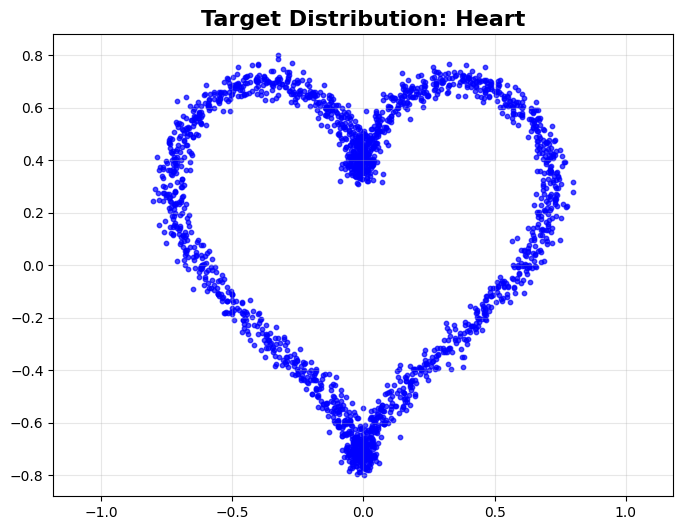

In [19]:
print(f"Generating real data ({DATASET_TYPE})")
real_data = generate_real_data(n_samples=N_SAMPLES, dataset_type=DATASET_TYPE, device=device)
print(f"Generated {len(real_data):,} samples on {device}")

plt.figure(figsize=(8, 6))
real_np = real_data.cpu().numpy()
plt.scatter(real_np[:, 0], real_np[:, 1], alpha=0.7, c='blue', s=10)
plt.title(f'Target Distribution: {DATASET_TYPE.capitalize()}', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

In [20]:
generator = Generator(noise_dim=NOISE_DIM)
discriminator = Discriminator()

# Move to device and get parameter counts
generator.to(device)
discriminator.to(device)

gen_params = sum(p.numel() for p in generator.parameters())
disc_params = sum(p.numel() for p in discriminator.parameters())
total_params = gen_params + disc_params

print(f"Generator parameters: {gen_params:,}")
print(f"Discriminator parameters: {disc_params:,}")
print(f"Total parameters: {total_params:,}")

Generator parameters: 26,818
Discriminator parameters: 25,217
Total parameters: 52,035


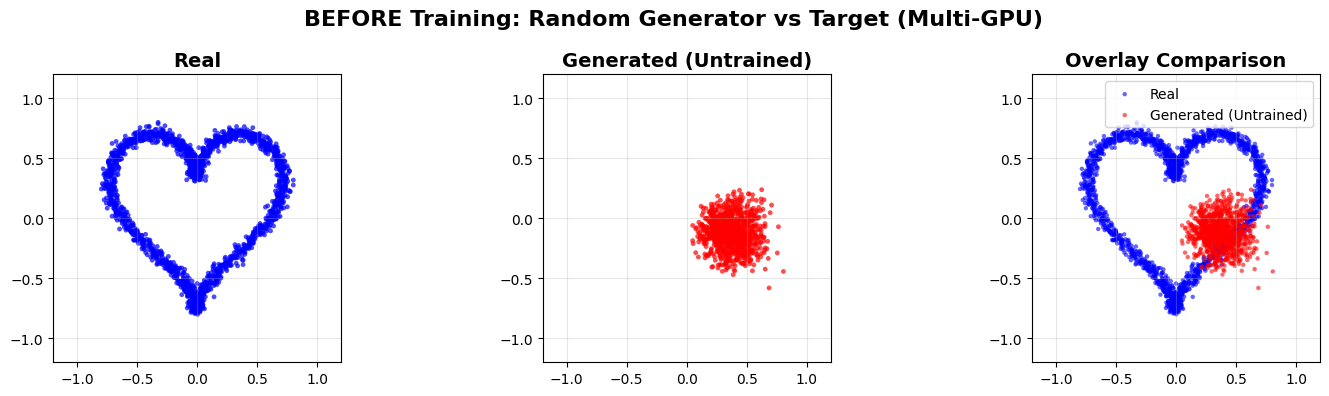

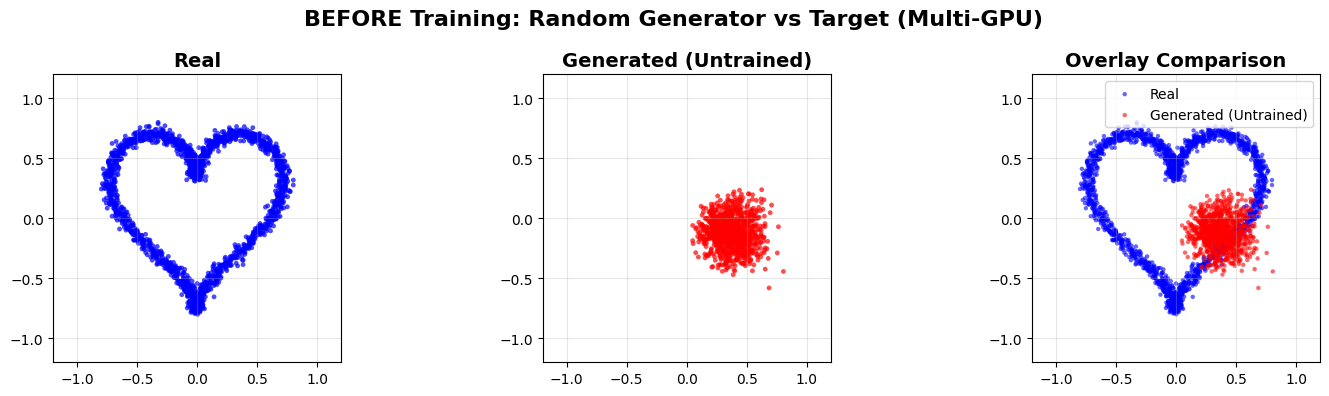

In [21]:
initial_samples = generate_samples(generator, NOISE_DIM, 1000, device)
plot_data_comparison(
    real_data, initial_samples,
    title_prefix=f"BEFORE Training: Random Generator vs Target {device_name}",
    fake_label="Generated (Untrained)",
    fake_color='red'
)

**Analysis of BEFORE state**:
- Untrained generator produces random, unstructured data
- No resemblance to target distribution

Using DataParallel for multi-GPU training
Starting stable GAN training...
Generator LR: 0.0002, Discriminator LR: 0.0001
Batch size: 1024, Epochs: 2000
------------------------------------------------------------
Epoch    0 | D_loss: 0.1992 | G_loss: 0.1792 | Time: 1.6s
Epoch  500 | D_loss: 0.2009 | G_loss: 0.2039 | Time: 48.4s


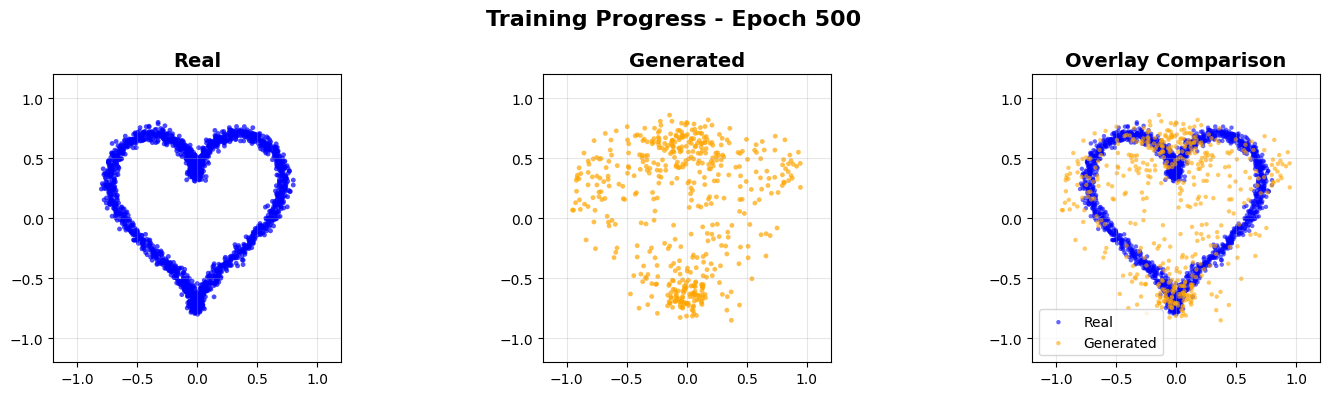

Epoch 1000 | D_loss: 0.2023 | G_loss: 0.2031 | Time: 94.6s


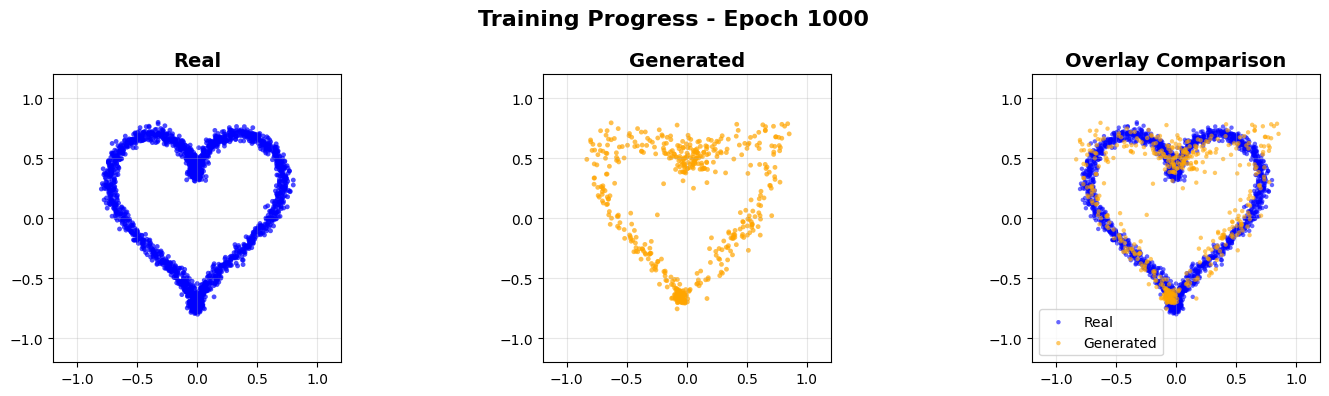

Epoch 1500 | D_loss: 0.2028 | G_loss: 0.2035 | Time: 141.0s


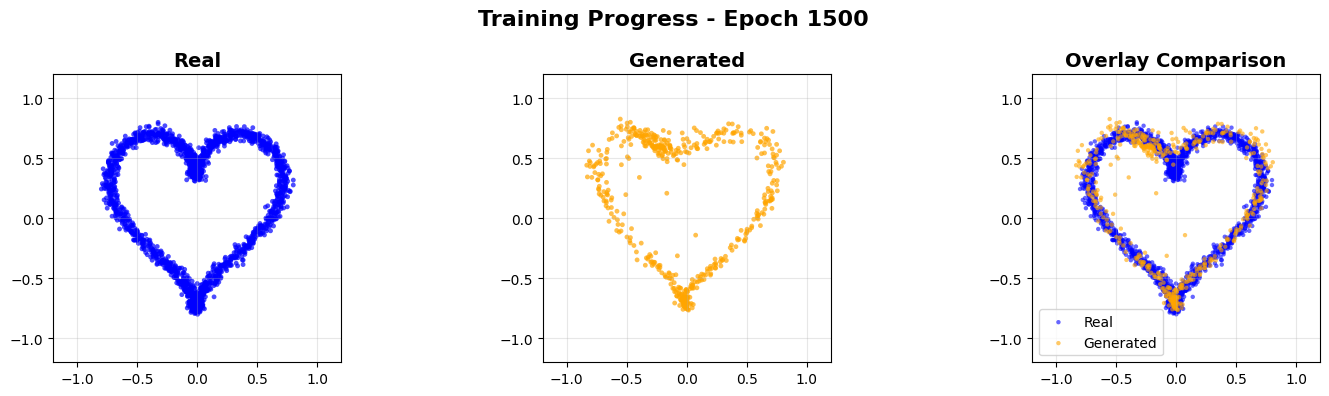


Training completed in 186.4 seconds!


In [22]:
# GAN Training
g_losses, d_losses = train_gan(
    generator, discriminator, real_data, device, multi_gpu,
    noise_dim=NOISE_DIM, epochs=EPOCHS, batch_size=1024, lr_g=0.0002, lr_d=0.0001
)

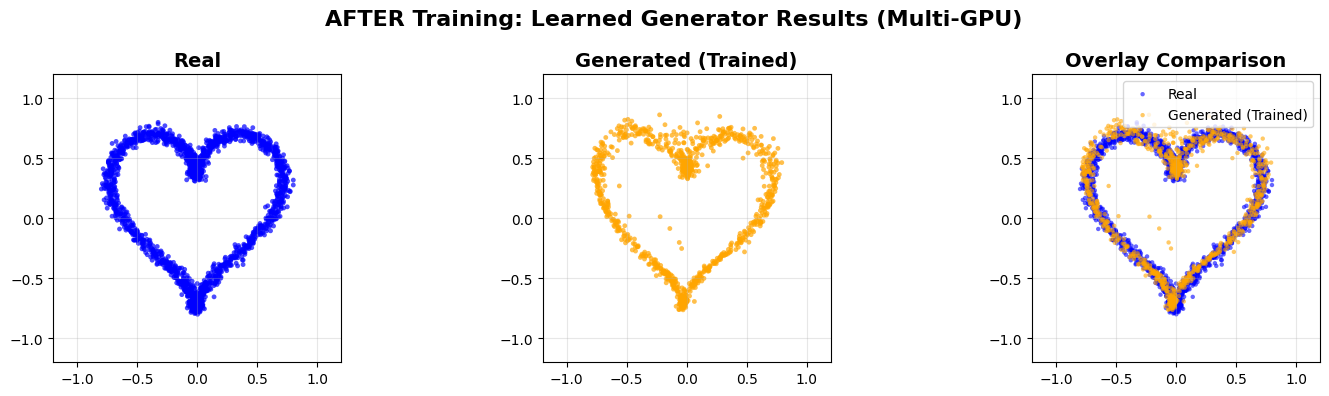

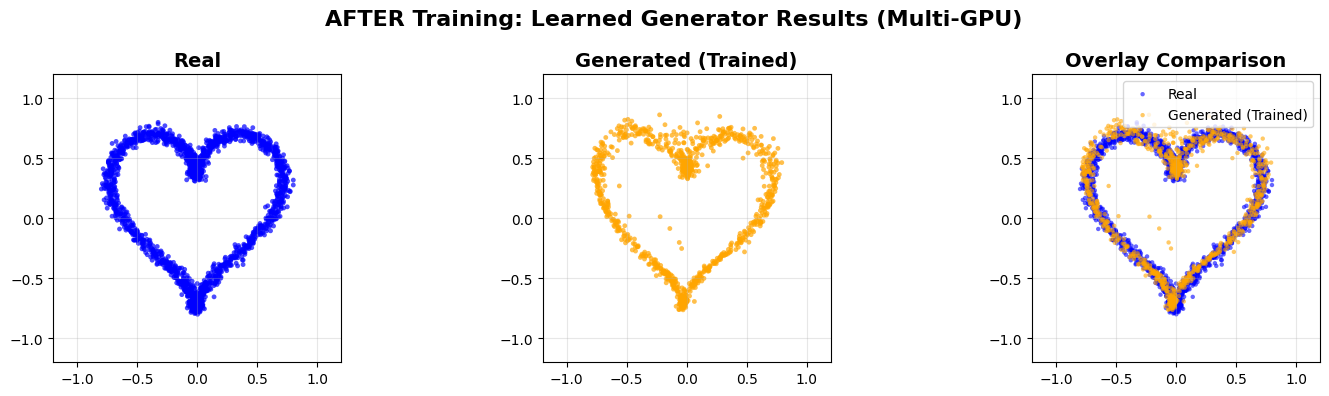

In [23]:
# Generated Data After Training
final_samples = generate_samples(generator, NOISE_DIM, 1000, device)
plot_data_comparison(
    real_data, final_samples,
    title_prefix=f"AFTER Training: Learned Generator Results {device_name}",
    fake_label="Generated (Trained)",
    fake_color='orange'
)

**Analysis of AFTER state**:
- Generated data should now closely matches target distribution!
- Clear improvement from random scatter to structured pattern
- GAN successfully learned the underlying data distribution

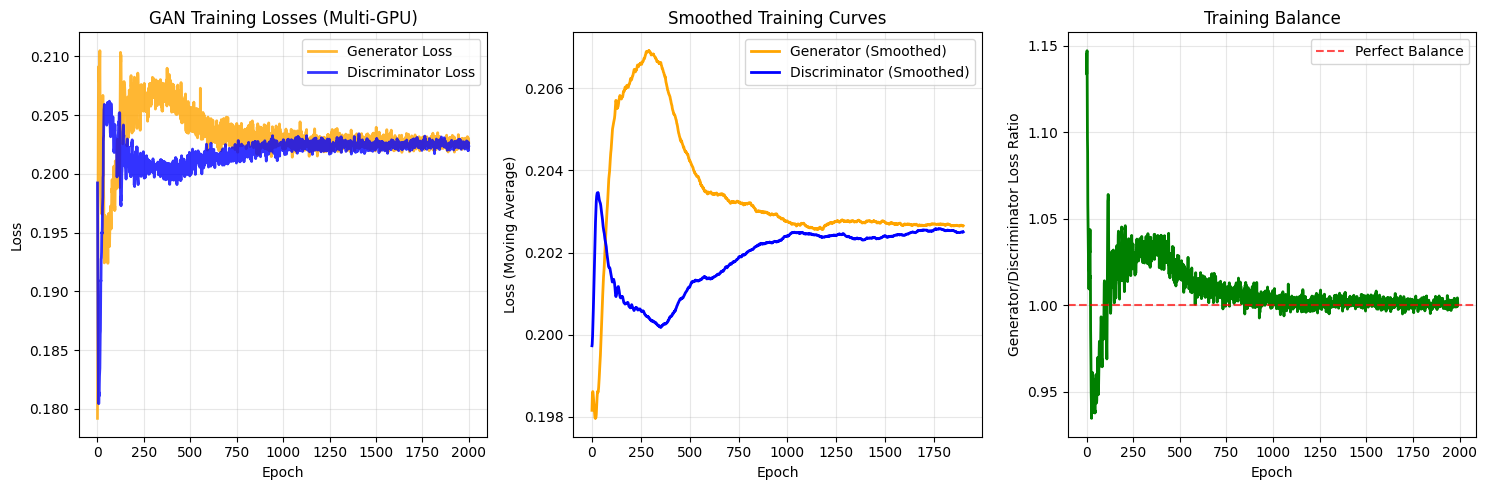

In [24]:
# Analyzing training dynamics...
plot_training_losses(g_losses, d_losses, device_name)

**Key Observations**:
- Generator loss should generally decrease over time
- Discriminator loss should stabilize (not go to zero)
- Loss ratio near 1.0 indicates good balance
- Some oscillation is normal in adversarial training

In [25]:
print(f"\nResults Summary:")
print(f"   Dataset: {DATASET_TYPE}")
print(f"   Training epochs: {EPOCHS}")
print(f"   Final Generator loss: {g_losses[-1]:.4f}")
print(f"   Final Discriminator loss: {d_losses[-1]:.4f}")
print(f"   Device used: {device} {device_name}")

if torch.cuda.is_available():
    memory_used = torch.cuda.max_memory_allocated() / 1e9
    print(f"   Peak GPU memory: {memory_used:.2f} GB")

# Cleanup
if torch.cuda.is_available():
    torch.cuda.empty_cache()


Results Summary:
   Dataset: heart
   Training epochs: 2000
   Final Generator loss: 0.2027
   Final Discriminator loss: 0.2024
   Device used: cuda:0 (Multi-GPU)
   Peak GPU memory: 0.04 GB


**Key Takeaways**:
- GANs transform random noise into structured, realistic data
- Training involves competition between generator and discriminator
- Proper balance is crucial - neither network should dominate
- Visual comparison shows dramatic improvement from training

**Try These Experiments**:
- Change DATASET_TYPE to see different patterns
- Adjust EPOCHS for longer/shorter training
- Modify NOISE_DIM to see effect on diversity
- Try different learning rates in train_gan()

## Part 3: HuggingFace Introduction

**Instructions**:
1. Create Your HuggingFace Account at https://huggingface.co/, if you don't already have one.
2. Go to **"Settings"** and then **"Access Tokens"**.
3. Generate a **"New token"** with Read permissions
4. Copy and save your token immediately.

In [26]:
import os
from huggingface_hub import login

# TODO: Get your own HuggingFace Token and add it here.

def setup_huggingface_auth():
    """ Set up Hugging Face authentication """
    
    hf_token = "hf_YOUR_TOKEN_HERE"
    
    try:
        login(token=hf_token, add_to_git_credential=False)
        print("Successfully authenticated with Hugging Face")
        return hf_token
    except Exception as e:
        print(f"Authentication failed: {e}")
        print("Please check your token and try again")
        return None

# Authenticate
HF_TOKEN = setup_huggingface_auth()

Successfully authenticated with Hugging Face


In [27]:
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
from PIL import Image

warnings.filterwarnings("ignore")

In [28]:
# Initialize a simple text generation pipeline

text_generator = pipeline(
    "text-generation",
    model="microsoft/DialoGPT-small",  # Small model for demo
    device=device
)

print("Model loaded successfully!")

# Test text generation
prompt = "The future of AI in education is"
result = text_generator(
    prompt, 
    max_length=50, 
    num_return_sequences=1,
    truncation=True,          # silence truncation warning
    pad_token_id=50256        # ensure consistent padding
    )

print(f"\nText Generation:")
print(f"Prompt: '{prompt}'")
print(f"Generated: '{result[0]['generated_text']}'")

Device set to use cuda:0
Both `max_new_tokens` (=256) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Model loaded successfully!

Text Generation:
Prompt: 'The future of AI in education is'
Generated: 'The future of AI in education is looking bleak.'


---
- HuggingFace provides pre-trained models
- 'pipeline' abstracts away complexity
- No training required - just use!

**HuggingFace Architecture**:
- The Hub (huggingface.co/models):
- 400,000+ pre-trained models
- Models for every AI task imaginable
- Community contributions and official models

**Key Libraries**:
- transformers: NLP models (BERT, GPT, etc.)
- diffusers: Image generation models
- datasets: Pre-processed datasets
- accelerate: Multi-GPU training

**Pipeline Pattern**:
- High-level API for common tasks
- Handles tokenization, model loading, post-processing
- Perfect for rapid prototyping

In [29]:
from transformers import pipelines
import random

available_tasks = list(pipelines.SUPPORTED_TASKS.keys())
random_tasks = random.sample(available_tasks, 10)

print(f"\nAvailable Pipeline Tasks ({len(available_tasks)} total):")
for task in random_tasks:
    print(f"   • {task}")
print("   • ... and many more!")


Available Pipeline Tasks (29 total):
   • translation
   • image-feature-extraction
   • question-answering
   • zero-shot-classification
   • zero-shot-image-classification
   • image-to-image
   • object-detection
   • visual-question-answering
   • automatic-speech-recognition
   • token-classification
   • ... and many more!


In [30]:
# Stable Diffusion Pipeline
from diffusers import StableDiffusionPipeline

# Load the Stable Diffusion pipeline
model_id = "runwayml/stable-diffusion-v1-5"

# For CPU (slower but works everywhere)
if device == "cpu":
    pipe = StableDiffusionPipeline.from_pretrained(
        model_id,
        torch_dtype=torch.float32
    )
    pipe = pipe.to(device)
else:
    # For GPU (much faster)
    pipe = StableDiffusionPipeline.from_pretrained(
        model_id,
        torch_dtype=torch.float16
    )
    pipe = pipe.to(device)

print("Stable Diffusion loaded successfully!")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Stable Diffusion loaded successfully!


  0%|          | 0/20 [00:00<?, ?it/s]

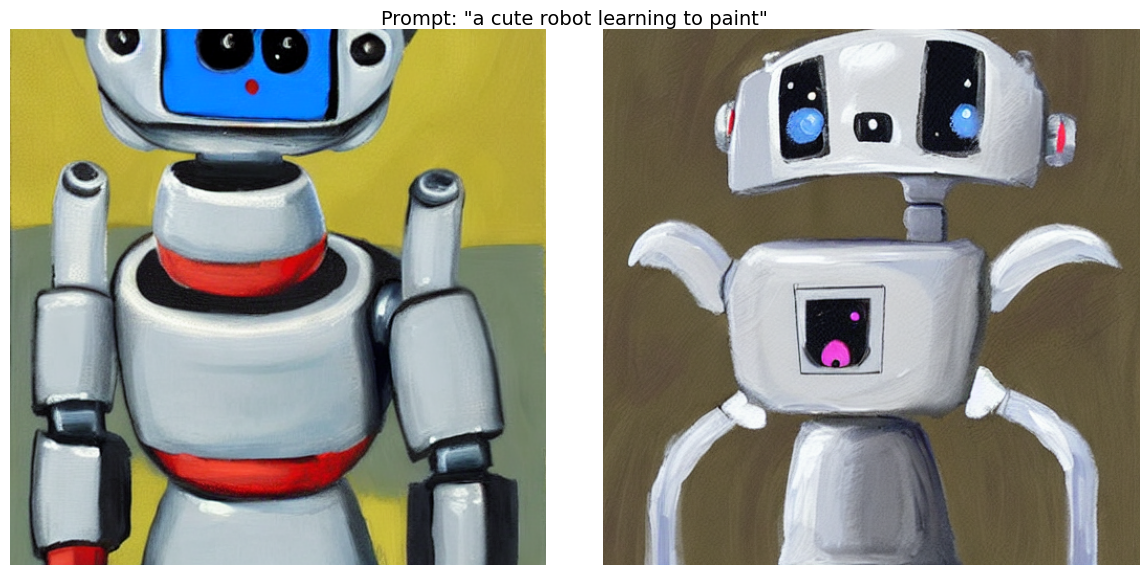

Generated 2 images successfully!



  0%|          | 0/20 [00:00<?, ?it/s]

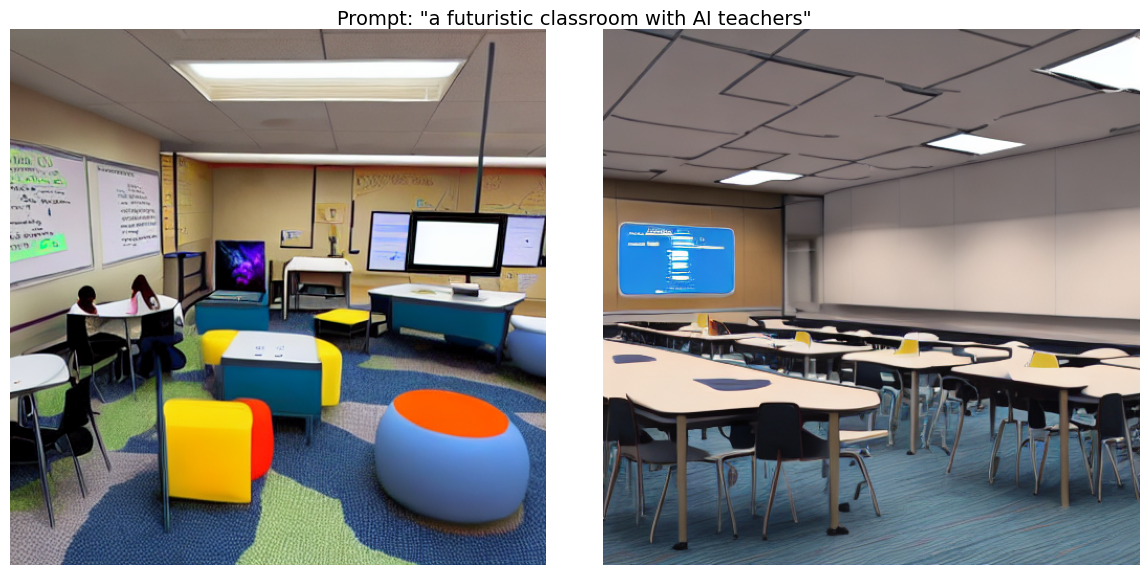

Generated 2 images successfully!



  0%|          | 0/20 [00:00<?, ?it/s]

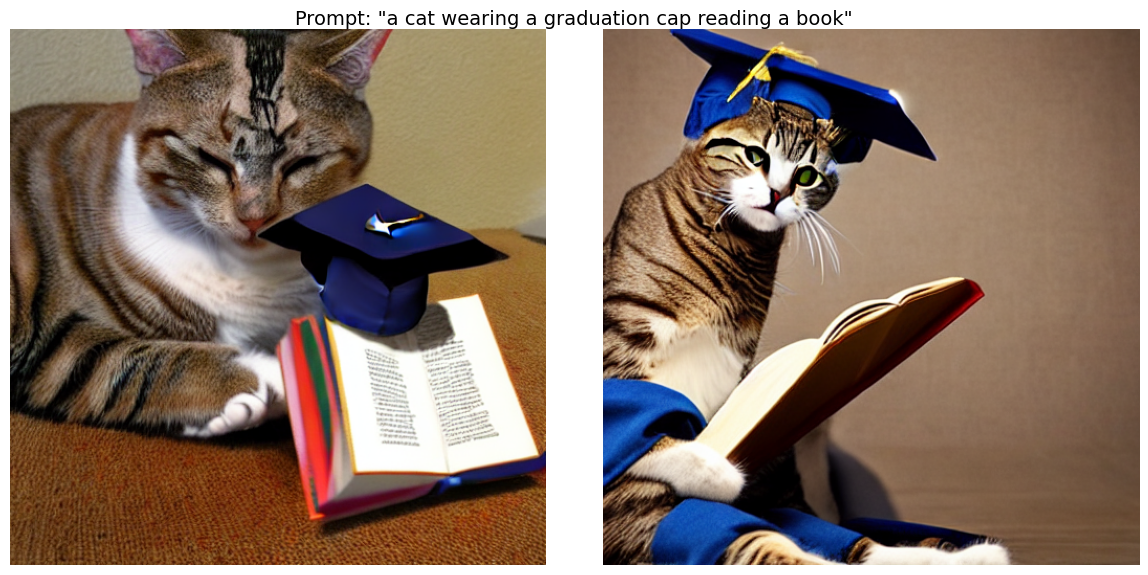

Generated 2 images successfully!



In [31]:
def generate_and_display(prompt, num_images=2):
    """Generate and display images from text prompt"""
    
    # Autocast for GPU acceleration
    with torch.autocast(device_type=device.type):
        images = pipe(
            prompt,
            num_inference_steps=20,   # Fewer steps = faster, but lower quality
            guidance_scale=7.5,       # How closely to follow the prompt
            num_images_per_prompt=num_images
        ).images
    
    # Display results
    fig, axes = plt.subplots(1, num_images, figsize=(12, 6))
    if num_images == 1:
        axes = [axes]
    
    for i, (img, ax) in enumerate(zip(images, axes)):
        ax.imshow(img)
        ax.axis('off')
    
    plt.suptitle(f'Prompt: \"{prompt}\"', fontsize=14, y=0.95)
    plt.tight_layout()
    plt.show()
    
    return images

# Let's generate some images!
prompts_to_try = [
    "a cute robot learning to paint",
    "a futuristic classroom with AI teachers",
    "a cat wearing a graduation cap reading a book"
]

for prompt in prompts_to_try:
    images = generate_and_display(prompt, num_images=2)
    print(f"Generated {len(images)} images successfully!\n")

   Generating with guidance_scale=1.0...


  0%|          | 0/20 [00:00<?, ?it/s]

   Generating with guidance_scale=7.5...


  0%|          | 0/20 [00:00<?, ?it/s]

   Generating with guidance_scale=15.0...


  0%|          | 0/20 [00:00<?, ?it/s]

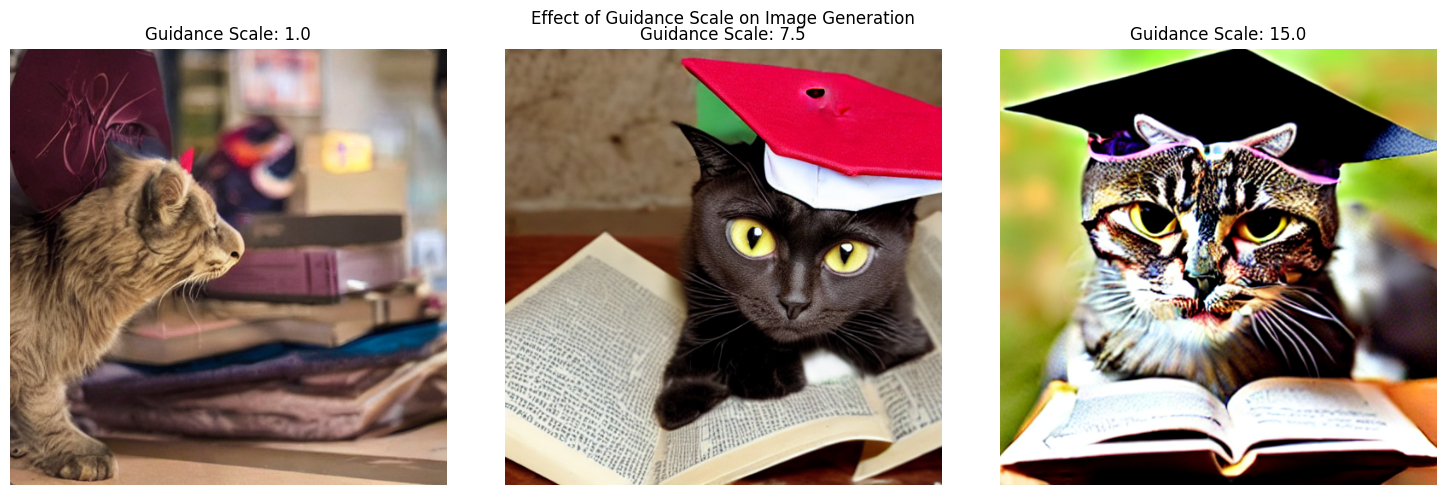

In [32]:
# Parameter exploration
prompt = "a cat wearing a graduation cap reading a book"

# Different guidance scales
guidance_scales = [1.0, 7.5, 15.0]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, scale in enumerate(guidance_scales):
    print(f"   Generating with guidance_scale={scale}...")
    
    with torch.autocast(device_type=device.type):
        image = pipe(
            prompt,
            num_inference_steps=20,
            guidance_scale=scale,
            num_images_per_prompt=1
        ).images[0]
    
    axes[i].imshow(image)
    axes[i].set_title(f'Guidance Scale: {scale}')
    axes[i].axis('off')

plt.suptitle('Effect of Guidance Scale on Image Generation')
plt.tight_layout()
plt.show()

**Parameter Effects**:
- guidance_scale=1.0: More creative, less prompt adherence
- guidance_scale=7.5: Balanced (recommended)
- guidance_scale=15.0: Strict prompt following, less creativity

---
**Navigating the HuggingFace Model Hub**:
Go to: https://huggingface.co/models
 
**Key Filters to Understand**:
- Task: What the model does (text-generation, image-to-text, etc.)
- Library: Which framework (transformers, diffusers, etc.)
- Language: For text models
- License: Important for commercial use

**Popular Model Categories for Our Course**:
- Text Generation:, GPT-2, GPT-J, FLAN-T5, Meta's LLaMA models
- Image Generation: Stable Diffusion variants, DALL-E mini
- Text-to-Image: stable-diffusion-v1-5, stable-diffusion-2-1

In [33]:
# Quick demo: Load a different model type

classifier = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
sentiment = classifier("HuggingFace makes AI development so much easier!")

print(f"Sentiment Analysis: {sentiment[0]['label']} ({sentiment[0]['score']:.3f})")

Device set to use cuda:0


Sentiment Analysis: POSITIVE (0.993)
